In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    f1_score
)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Reproducibility
np.random.seed(42)
tf.random.set_seed(42)


In [7]:
BASE_DIR = Path.cwd()
train_path = BASE_DIR / "mitbih_train.csv"
test_path  = BASE_DIR / "mitbih_test.csv"

print("Notebook folder:", BASE_DIR)
print("Train exists:", train_path.exists())
print("Test exists :", test_path.exists())

train_df = pd.read_csv(train_path, header=None)
test_df  = pd.read_csv(test_path, header=None)

print(f"Training set shape: {train_df.shape}")
print(f"Test set shape:     {test_df.shape}")
print("GPU available:", len(tf.config.list_physical_devices('GPU')) > 0)

train_df.head()


Notebook folder: d:\MLInMedicine
Train exists: True
Test exists : True
Training set shape: (87554, 188)
Test set shape:     (21892, 188)
GPU available: False


,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
X_train_full = train_df.iloc[:, :-1].values.astype(np.float32)
y_train_full = train_df.iloc[:, -1].values.astype(int)

X_test = test_df.iloc[:, :-1].values.astype(np.float32)
y_test = test_df.iloc[:, -1].values.astype(int)

class_names = {
    0: "Normal",
    1: "Supraventricular",
    2: "Ventricular",
    3: "Fusion",
    4: "Unknown"
}

num_classes = len(class_names)


In [9]:
def print_distribution(y, title):
    uniq, cnt = np.unique(y, return_counts=True)
    print(title)
    for u, c in zip(uniq, cnt):
        print(f"  {u} ({class_names[u]}): {c} ({c/len(y)*100:.2f}%)")
    print()

print_distribution(y_train_full, "Training distribution:")
print_distribution(y_test, "Test distribution:")


Training distribution:
  0 (Normal): 72471 (82.77%)
  1 (Supraventricular): 2223 (2.54%)
  2 (Ventricular): 5788 (6.61%)
  3 (Fusion): 641 (0.73%)
  4 (Unknown): 6431 (7.35%)

Test distribution:
  0 (Normal): 18118 (82.76%)
  1 (Supraventricular): 556 (2.54%)
  2 (Ventricular): 1448 (6.61%)
  3 (Fusion): 162 (0.74%)
  4 (Unknown): 1608 (7.35%)



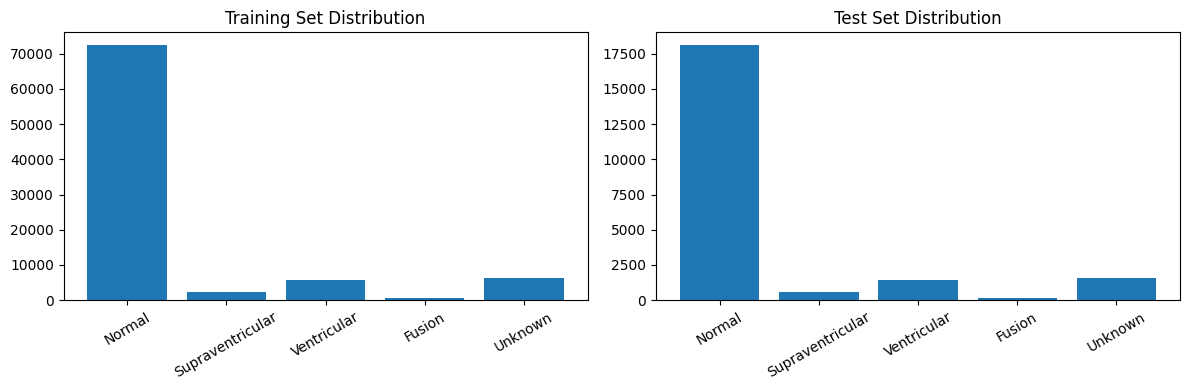

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

uniq, cnt = np.unique(y_train_full, return_counts=True)
ax[0].bar([class_names[i] for i in uniq], cnt)
ax[0].set_title("Training Set Distribution")
ax[0].tick_params(axis="x", rotation=30)

uniq2, cnt2 = np.unique(y_test, return_counts=True)
ax[1].bar([class_names[i] for i in uniq2], cnt2)
ax[1].set_title("Test Set Distribution")
ax[1].tick_params(axis="x", rotation=30)

plt.tight_layout()
plt.show()


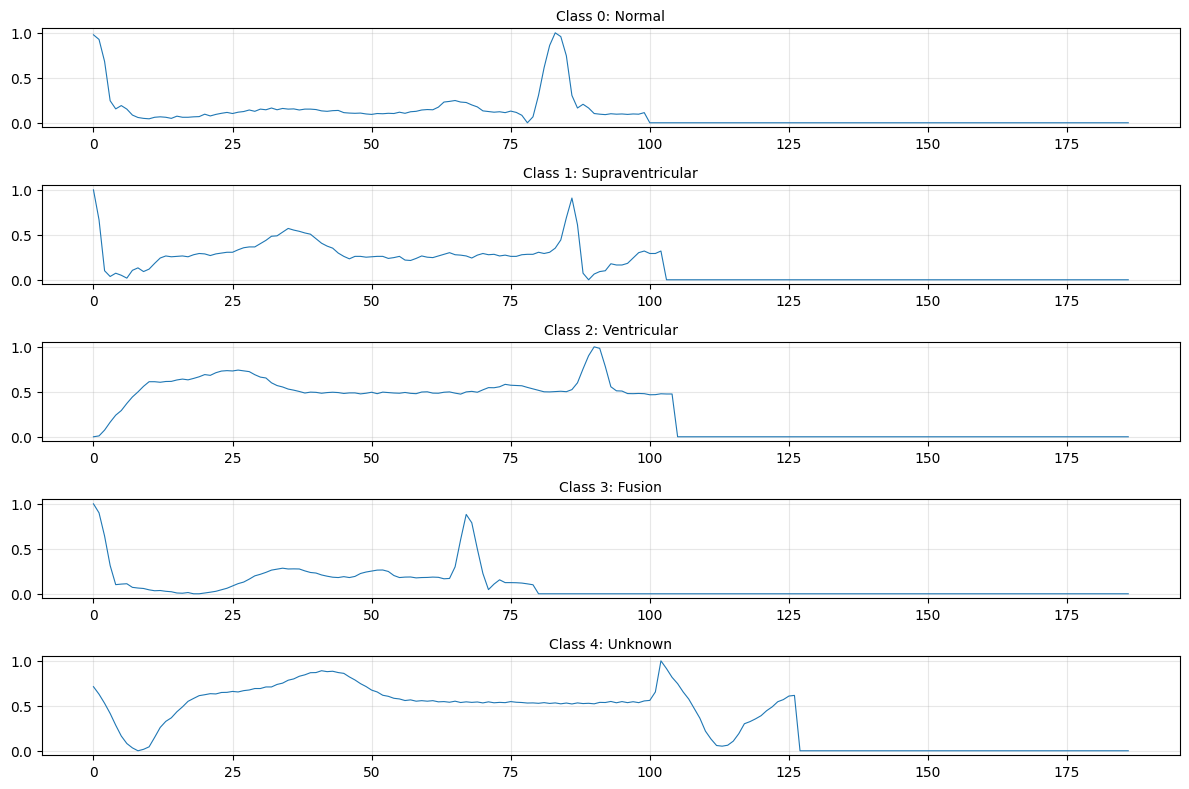

In [11]:
plt.figure(figsize=(12, 8))

for cls in range(num_classes):
    idx = np.where(y_train_full == cls)[0][0]
    plt.subplot(num_classes, 1, cls + 1)
    plt.plot(X_train_full[idx], linewidth=0.8)
    plt.title(f"Class {cls}: {class_names[cls]}", fontsize=10)
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [12]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full,
    y_train_full,
    test_size=0.15,
    random_state=42,
    stratify=y_train_full
)

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_val_sc   = scaler.transform(X_val)
X_test_sc  = scaler.transform(X_test)


In [13]:
X_train_seq = X_train_sc.reshape(X_train_sc.shape[0], X_train_sc.shape[1], 1)
X_val_seq   = X_val_sc.reshape(X_val_sc.shape[0], X_val_sc.shape[1], 1)
X_test_seq  = X_test_sc.reshape(X_test_sc.shape[0], X_test_sc.shape[1], 1)

print("X_train_seq:", X_train_seq.shape)
print("X_val_seq:  ", X_val_seq.shape)
print("X_test_seq: ", X_test_seq.shape)


X_train_seq: (74420, 187, 1)
X_val_seq:   (13134, 187, 1)
X_test_seq:  (21892, 187, 1)


In [14]:
model = keras.Sequential([
    layers.Input(shape=(X_train_seq.shape[1], 1)),
    layers.LSTM(64),
    layers.Dropout(0.3),
    layers.Dense(32, activation="relu"),
    layers.Dense(num_classes, activation="softmax")
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,141 (74.77 KB)

 Trainable params: 19,141 (74.77 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=7,
        restore_best_weights=True
    )
]

history = model.fit(
    X_train_seq,
    y_train,
    validation_data=(X_val_seq, y_val),
    epochs=40,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/40
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 59s 49ms/step - accuracy: 0.8266 - loss: 0.6622 - val_accuracy: 0.8279 - val_loss: 0.6332
Epoch 2/40
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 53s 46ms/step - accuracy: 0.8279 - loss: 0.6231 - val_accuracy: 0.8289 - val_loss: 0.6242
Epoch 3/40
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 53s 46ms/step - accuracy: 0.8299 - loss: 0.6288 - val_accuracy: 0.8447 - val_loss: 0.6084
Epoch 4/40
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 54s 46ms/step - accuracy: 0.8333 - loss: 0.5917 - val_accuracy: 0.8282 - val_loss: 0.5246
Epoch 5/40
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 55s 47ms/step - accuracy: 0.8328 - loss: 0.6188 - val_accuracy: 0.8292 - val_loss: 0.6482
Epoch 6/40
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 54s 47ms/step - accuracy: 0.8285 - loss: 0.6519 - val_accuracy: 0.8290 - val_loss: 0.6464
Epoch 7/40
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 54s 46ms/step - accuracy: 0.8289 - loss: 0.6435 - val_accuracy: 0.8292 - val_loss: 0.6340
Epoch 8/40
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 54s 46ms/step - accuracy: 0.8289 -

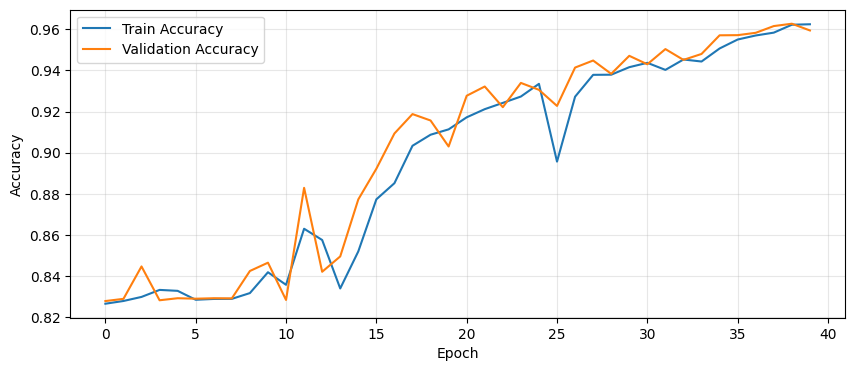

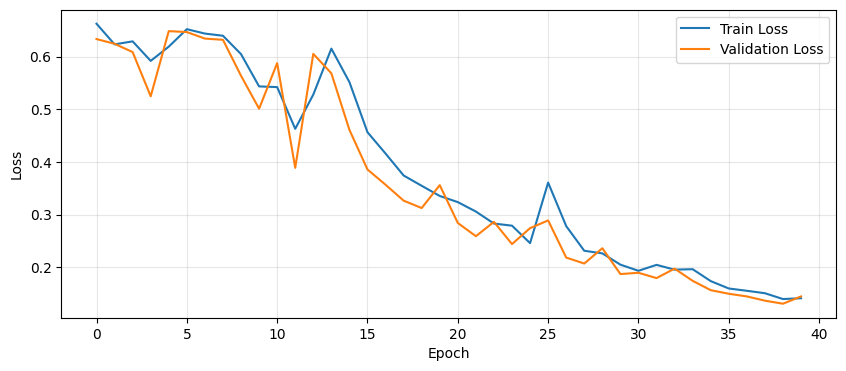

In [16]:
plt.figure(figsize=(10, 4))
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


In [17]:
y_proba = model.predict(X_test_seq, verbose=0)
y_pred = np.argmax(y_proba, axis=1)

acc = accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average="macro")

print(f"Test Accuracy: {acc:.4f}")
print(f"Test Macro F1: {macro_f1:.4f}\n")

print("Classification Report:")
print(classification_report(
    y_test,
    y_pred,
    target_names=[class_names[i] for i in range(num_classes)],
    zero_division=0
))


Test Accuracy: 0.9608
Test Macro F1: 0.8057

Classification Report:
                  precision    recall  f1-score   support

          Normal       0.97      0.99      0.98     18118
Supraventricular       0.75      0.56      0.64       556
     Ventricular       0.91      0.86      0.89      1448
          Fusion       0.60      0.57      0.58       162
         Unknown       0.96      0.92      0.94      1608

        accuracy                           0.96     21892
       macro avg       0.84      0.78      0.81     21892
    weighted avg       0.96      0.96      0.96     21892



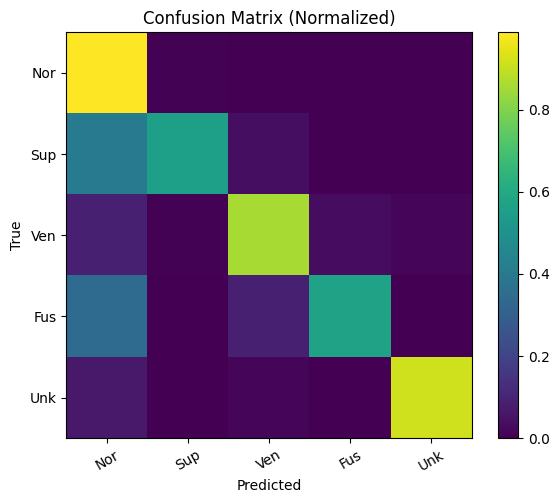

In [18]:
cm = confusion_matrix(y_test, y_pred)
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(6, 5))
plt.imshow(cm_norm, interpolation="nearest")
plt.title("Confusion Matrix (Normalized)")
plt.colorbar()

ticks = np.arange(num_classes)
plt.xticks(ticks, [class_names[i][:3] for i in range(num_classes)], rotation=30)
plt.yticks(ticks, [class_names[i][:3] for i in range(num_classes)])
plt.xlabel("Predicted")
plt.ylabel("True")

plt.tight_layout()
plt.show()


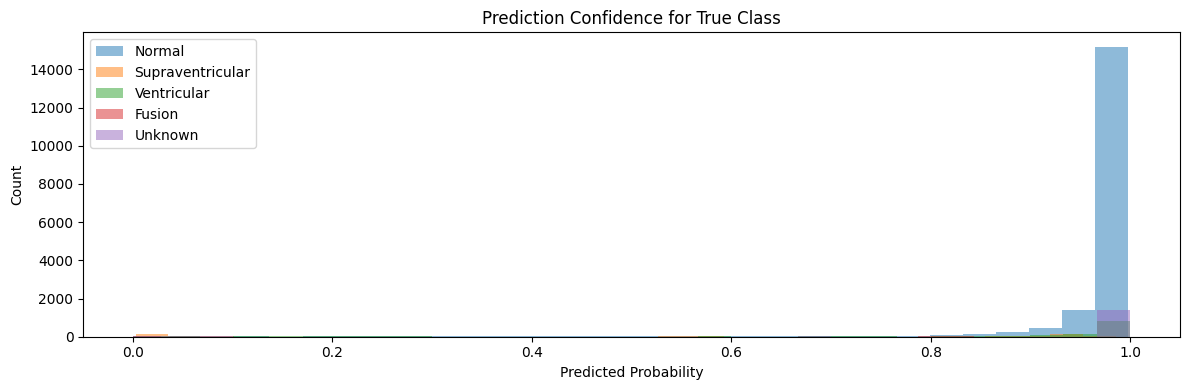

In [19]:
plt.figure(figsize=(12, 4))
for cls in range(num_classes):
    cls_mask = (y_test == cls)
    plt.hist(
        y_proba[cls_mask, cls],
        bins=30,
        alpha=0.5,
        label=class_names[cls]
    )

plt.title("Prediction Confidence for True Class")
plt.xlabel("Predicted Probability")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()
